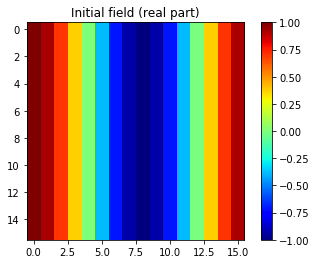

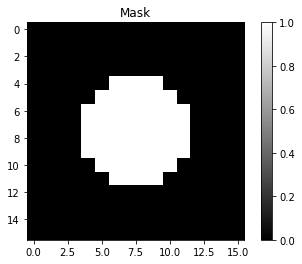

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special
import copy


def empty_mask(size):
    return np.zeros((size,size))

def circular_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[(x-x0)**2+(y-y0)**2<=r**2]=1
    return M

def rectangle_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[((x-x0)**2<=r**2)*((y-y0)**2<=r**2)]=1
    return M
    

    
def get_plane_wave(E0,k,size):
    y,x = np.mgrid[:size, :size]
    a = np.pi*0/180
    E = E0*np.exp(-1j*k*(x*np.cos(a)+y*np.sin(a)))
    return(E) 
    
def get_greenfun(r,k):
    return (1j/4)*scipy.special.hankel1(0,k*r)

def get_green_matrix(k,size):
    j,i = np.mgrid[:size, :size]
    ij_block = np.sqrt((i-1/2)**2+j**2)
    green_mat = get_greenfun(ij_block,k)
    return green_mat

# def get_toeplitz_mat(ij_block):
#     ij_block = copy.deepcopy(ij_block)
#     T = np.block([[ij_block,ij_block[:,:0:-1]],
#                   [ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]]])
#     return T

def get_toeplitz_mat(ij_block):
    ij_block = copy.deepcopy(ij_block)
    T1 = np.hstack((ij_block,ij_block[:,:0:-1]))
    T2 = np.hstack((ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]))
    T = np.vstack((T1,T2))
    return T
    
def G_matvec(vec,k):
    size = int(np.sqrt(vec.shape[0]))
    G_block = get_green_matrix(k,size)
    G = get_toeplitz_mat(G_block)
    mat = np.zeros((2*size-1,2*size-1),dtype = np.complex64)
    mat_block = vec.reshape((-1,size))
    mat[:size,:size] = mat_block
    out_mat = np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(mat))
    out = out_mat[:size,:size].reshape((-1,1))
    return out

def get_eps_from_mask(e,mask):
    return (e-1)*mask.reshape((-1,1))+1

def matvec(x,eps,k):
    x = x.reshape((-1,1))
    #print(x)
    size = x.shape[0]
    chi = k**2*(eps - 1)
    return x-G_matvec(x*chi,k)

def old_matvec(x,mask,k,e):
    eps = get_eps_from_mask(e,mask)
    return matvec(x,eps,k)

def visualize(data,title = "",cmap='jet',):
    plt.title(title)
    neg = plt.imshow(data, cmap=cmap, interpolation='none')
    plt.colorbar(neg)
    plt.show()


    
def solve(E,eps0,eps1):
    return E


size = 16
e =1.5# 2.25
k  = 2*np.pi/(size/1)
F = get_plane_wave(1,k,size)
#mask = empty_mask(size)
#mask = rectangle_mask(size)
mask = circular_mask(size)
eps = get_eps_from_mask(e,mask)
visualize(F.real,"Initial field (real part)")
visualize(mask,"Mask","gray")

    



-0.010435104370117188


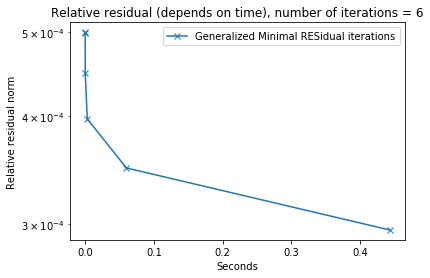

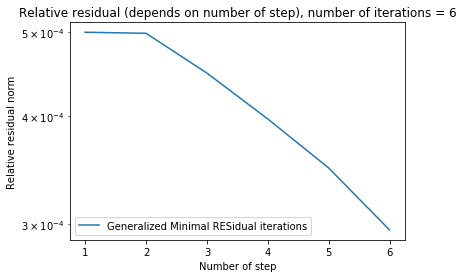

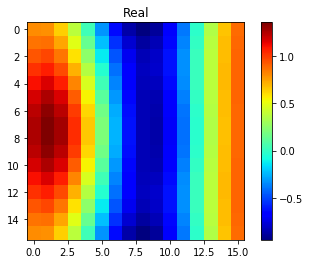

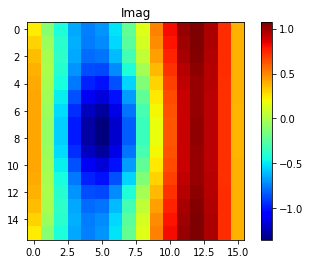

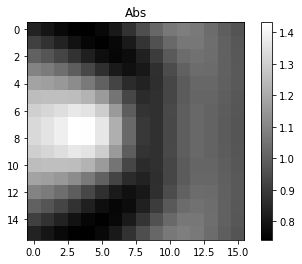

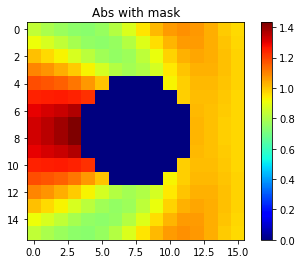

In [10]:
import scipy.sparse.linalg as spla
import inspect
import time

x_last = get_plane_wave(1,k,size).reshape(-1,1)
def plot__solution_re_im_abs_mask(solution, size):
    solution_re = solution.real.reshape(-1,size)
    solution_im = solution.imag.reshape(-1,size)
    solution_abs = np.abs(solution).reshape(-1,size)
    solution_abs_mask = np.abs(solution).reshape(-1,size)*(1-mask)
    visualize(solution_re,"Real")
    visualize(solution_im,"Imag")
    visualize(solution_abs,"Abs","gray")
    visualize(solution_abs_mask,"Abs with mask")
    return solution_re, solution_im, solution_abs, solution_abs_mask

def plot_relative_residuals_norms(t, residuals, relative_vector):
    plt.semilogy(t, residuals/np.linalg.norm(relative_vector), 'x-', label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on time), number of iterations = %i' % len(residuals))
    plt.xlabel('Seconds')
    plt.ylabel('Relative residual norm')
    plt.show()
    plt.semilogy(np.arange(len(residuals), 0, -1), residuals/np.linalg.norm(relative_vector), label="Generalized Minimal RESidual iterations")
    plt.legend()
    plt.title('Relative residual (depends on number of step), number of iterations = %i' % len(residuals))
    plt.xlabel('Number of step')    
    plt.ylabel('Relative residual norm')
    plt.show()
    
def gmres_solver(A, b, x0, maxiter, tol, 
                 draw_graph_flag = False, 
                 convergence_info = False, 
                 display_convergence_info = False,
                 display_achieved_tolerance = False):
    gmres_residuals_with_t = []
    t0 = time.time()
    solution, info =  spla.gmres(A, b,  x0=x0, maxiter = maxiter, tol = tol, restart  = maxiter, callback = lambda x:
        gmres_residuals_with_t.append([(inspect.currentframe().f_back).f_locals['resid'], time.time()])
        )
    if len(gmres_residuals_with_t)>1:
        gmres_residuals_with_t = np.array(gmres_residuals_with_t).T
        gmres_residuals_with_t[1] = gmres_residuals_with_t[1]-t0
        gmres_t, gmres_residuals = gmres_residuals_with_t
    else:
        gmres_t, gmres_residuals = [],[]
    if (display_convergence_info == True):
        if (info == 0):
            print("Status: Converged, successful exit")
        else:
            if (info > 0):
                print("Status: Convergence to tolerance not achieved, number of iterations")
            else:
                print("Status: Illegal input or breakdown")
    if ( draw_graph_flag == True ):
        plot_relative_residuals_norms(gmres_t, gmres_residuals, b)        
    if ( display_achieved_tolerance == True):
        print('Achieved tolerance = ', np.linalg.norm(A.dot(solution.reshape(-1,1))-b)/np.linalg.norm(b))
    if (convergence_info == True):
        return solution, info
    return solution

def launch_solver(eps, k, x0 = None ,maxiter=300, tol = 1e-6):
    global x_last
    size = int(np.sqrt(eps.shape[0]))
    A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
    b = get_plane_wave(1,k,size).reshape(-1,1)
    if x0 is None:
        x0 = x_last
    solution, info = gmres_solver(A, b, x0, 
                               maxiter=maxiter, 
                               tol=tol,
                               convergence_info = True)
    x_last = solution.reshape(-1,1)
    return solution, info

def show_residuals(eps, k, maxiter=300, tol = 1e-6):
    size = int(np.sqrt(eps.shape[0]))
    A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
    b = get_plane_wave(1,k,size).reshape(-1,1)
    x0 = np.ones(size**2).reshape(-1,1)
    gmres_solver(A, b, x0, 
                 maxiter=maxiter, 
                 tol=tol,
                 draw_graph_flag = True)
    
t = time.time()
solution, info = launch_solver(eps=eps, k=k)
print(t-time.time())
show_residuals(eps=eps, k=k)
solution_re, solution_im, solution_abs, solution_abs_mask = plot__solution_re_im_abs_mask(solution, size)

In [59]:
def choose_direction(eps, k, maxiter=300, tol=1e-6, x=None):
    if x is None:
        x, info = launch_solver(eps=eps, k=k, maxiter=maxiter, tol=tol)
    x_abs = np.abs(x)
    x_max = np.max(x_abs)
    indeces = np.argwhere( x_abs == x_max )
    choose_direction = np.zeros(x.shape[0], dtype = np.complex64)
    choose_direction[indeces] = (np.sign(x.real)/2+1j*np.sign(x.imag)/2)[indeces]/indeces.shape[0]
    return choose_direction

def get_Jacobi_diagonal(mask, e, k, eps = None, x0 = None , maxiter=300, tol = 1e-6):
    if eps is None:
        eps = get_eps_from_mask(e,mask)
    solution, info = launch_solver(eps=eps, x0=x0, k=k, maxiter=maxiter, tol = tol)
    solution_with_coeff = k**2*(e-1)*solution
    zero_vector = np.zeros(solution_with_coeff.shape[0], dtype = np.complex64)
    Jacobi_diagonal = np.zeros(solution.shape[0], dtype = np.complex64 )
    for i in range(solution.shape[0]):
        solution_sparse_column = zero_vector.copy()
        solution_sparse_column[i] = solution_with_coeff[i]
        A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
        b = G_matvec(solution_sparse_column, k)        
        Jacobi_diagonal[i] = gmres_solver(A=A, b=b, x0=solution, maxiter=maxiter, tol=tol)[i]
    return Jacobi_diagonal

def get_grad(mask, e=e, k=k, x = None, eps = None, x0 = None , maxiter=300, tol = 1e-6):
    if eps is None:
        eps = get_eps_from_mask(e,mask)
    solution, info = launch_solver(eps=eps, x0=x0, k=k, maxiter=maxiter, tol = tol)
    direction =  choose_direction(eps=eps, k=k, maxiter=maxiter, tol=tol, x=solution)
    solution_with_coeff = k**2*(e-1)*solution
    zero_vector = np.zeros(solution_with_coeff.shape[0], dtype = np.complex64)
    Jacobi_diagonal = np.zeros(solution.shape[0], dtype = np.complex64 )
    for i in np.argwhere(direction!=0):
        solution_sparse_column = zero_vector.copy()
        solution_sparse_column[i] = solution_with_coeff[i]
        A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,eps,k))
        b = G_matvec(solution_sparse_column, k)        
        Jacobi_diagonal[i] = gmres_solver(A=A, b=b, x0=solution, maxiter=maxiter, tol=tol)[i]
    return np.abs(Jacobi_diagonal)

print(get_grad(mask, e, k, maxiter=300, tol = 1e-6))

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

0.0
1.0
1.0
1.5


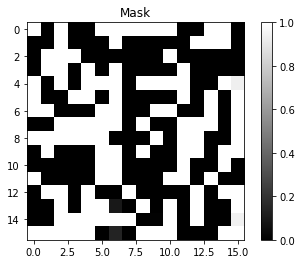

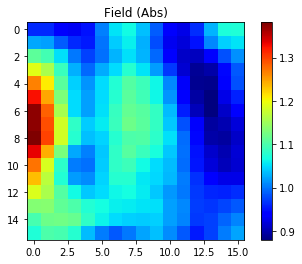

-1.38100812485
1.38100812789
1
2
3
4
5
6
0.0
1.0
1.0
1.5


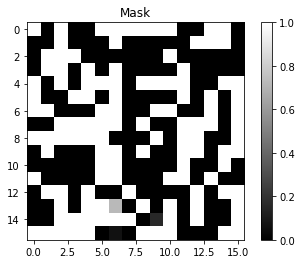

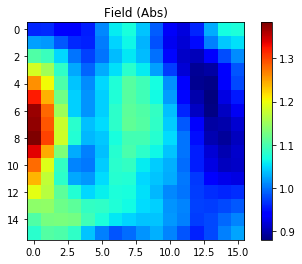

-1.38351072105
1.38351081771
-1.38100811813


In [27]:
from scipy.optimize import minimize

def plot_solution(y):
    mask = get_fild_value(y,20)
    
    print(np.min(mask))
    print(np.max(mask))
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    print(np.min(eps))
    print(np.max(eps))
    field, info = launch_solver(eps=eps, k=k)
    visualize(mask,"Mask","gray")
    #visualize(field.real.reshape(-1,size),"Field (Real part)")
    visualize(np.abs(field).reshape(-1,size),"Field (Abs)")
    print(objective(y))
    print(np.max(np.abs(field)))

i=0
def get_fild_value(y,p):
    x = (np.tanh(p*y)+1)/2
    return x

def callback(x):
    global i
    i+=1
    print(i)

def penalty(x,p):
    return np.sum(1-x**p-(1-x)**p)
    #return np.sum(x*(1-x))
#obj = 0
def objective(y):

    mask = get_fild_value(y,4)
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    field, info = launch_solver(eps=eps, k=k)

    
    #global obj
    mask = get_fild_value(y,20)
    eps = get_eps_from_mask(e,mask).reshape((-1,1))
    field, info = launch_solver(eps=eps, k=k)
    if info !=0:
        raise RuntimeError()
    obj = -np.max(np.abs(field))#+penalty(mask,20)*1
    #print(obj)
    return obj

#     x_empty_ind = np.argwhere((-0.1<mask)*(mask<0.1))
#     x_empty = x[x_empty_ind]
#     x_empty = x
#     if info != 0:
#         raise RuntimeError()
#     if x_empty.shape[0]!=0:
#         #print(np.max(x_empty.imag))
#         obj = -np.max(np.abs(x_empty))+penalty(mask,20)*0.001
#     else:
#         obj = penalty(mask,20)*0.001
#     #print(obj)
#     return obj

def get_random_mask(size):
    mask = np.random.rand(size,size)
    return mask

# def search_with_restarts(num):
    
#y = np.random.random(size,size)
# mask =circular_mask(size)
noize = (get_random_mask(size)-0.5)*10
# mask = (mask + noize)/np.max(noize+0.001)
y = circular_mask(size)-0.5+noize
obj0 = objective(y)
mask = get_fild_value(y,20)
plot_solution(y)
#bns = tuple((0,1) for _ in range(size**2))
sol = minimize(objective,y,method = "BFGS",options={'maxiter': 10, 'gtol':1e-9}, callback = callback)
best_y = sol.x.reshape(-1,size)
plot_solution(best_y)
print(obj0)


    

In [ ]:
# import cvxpy as cvx

# size = 2
# k  = 2*np.pi/(size/7)
# F = get_plane_wave(1,k,size)

# x = cvx.Variable(size**2)
# eps = cvx.Variable(size**2)
# y = cvx.Variable(1)



# # lambda val: matvec2(val,eps,k,e
# obj = cvx.Maximize(y)
# #A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda val: val)
# #print(A.dot([1,1,0,0]))
# costrs = [x>F.reshape(-1,1),y>=x]
# prob = cvx.Problem(obj,costrs)
# prob.solve()
# print(prob.value)